# 5.3 基于迁移学习技术来识别猫狗

## 在段到段的模式下定义基于全连接层+SVC的分类器

## 1 创建VGG16卷积基实例（使用卷积层，同时将部分全连接层作为分类器）

In [4]:
from keras.applications import VGG16

In [5]:
#创建VGG16实例，提前下载VGG16模型的h5文件，然后放置在C:\Users\Administrator\.keras\models
#要包含顶层，所以input_shape也能不随意指定
base_model = VGG16(weights = 'imagenet')

### 通过函数summary回顾下卷积基的网络结构，会看到全连接层也展现出来，稍后我们会使用一部分全连接层作为分类器

In [6]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### 我们将conv_base与flatten层、fc1层、fc2层放在一起作为预训练的模型
### 丢弃predictions层（即最后一个全连接层），后续我们将用支持向量分类器代替

In [7]:
from keras import Model
model = Model(inputs = base_model.input, outputs = base_model.get_layer('fc2').output)

## 2 使用预训练的VGG16模型的卷积基进行特征提取

In [8]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

### 设置训练集、验证集、测试集的图片目录

In [9]:
base_dir = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir, 'test')

### 创建数据生成器实例

### 场景1：不使用数据增强技术

In [10]:
#实例化ImageDataGenerator，不使用数据增强技术
datagen = ImageDataGenerator(rescale = 1./255)

# generator = datagen.flow_from_directory(test_dir,
#                                            target_size = (224,224),#要是用VGG16默认的input size
#                                            batch_size = 20,
#                                            class_mode = 'binary')

### 场景2：使用数据增强技术

In [11]:
#使用数据增强技术
# datagen = ImageDataGenerator(
#     rescale = 1./255,
#     rotation_range = 40,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
#     shear_range = 0.2,
#     zoom_range = 0.2,
#     horizontal_flip = True,
#     fill_mode = 'nearest')

### 定义特征提取函数
### 基于数据生成器将图像张量批量输入至卷积基，通过函数predict获取卷积基的特征张量
### 输入：提取图片样本目录；提取样本数
### 输出：返回VGG16卷积基输出的张量；样本对应的分类结果

In [14]:
#定义特征提取函数

batch_size = 20

#通过指定路径获取样本数进行特征提取
def extract_features(directory, sample_count):
    #初始化features,labels矩阵
    features_vgg16 = np.zeros(shape = (sample_count, 4096))#查询VGG16结构，得知fc2输出张量的size为(None, 4096)
    labels = np.zeros(shape = (sample_count))
    
    #生成器加载
    generator = datagen.flow_from_directory(directory,
                                           target_size = (224,224),#使用VGG16默认的输入张量size，可查询VGG16结构得到
                                           batch_size = batch_size,
                                           class_mode = 'binary')
    i = 0
    for fs,ls in generator:
        vgg16_output = model.predict(fs)#使用model（含fc层）的预测结果作为特征提取张量 
        features_vgg16[i*batch_size : (i+1)*batch_size] = vgg16_output
        labels[i*batch_size : (i+1)*batch_size] = ls
        i+=1
        if i*batch_size >= sample_count:
            break
    return features_vgg16,labels
    

### 对训练集、验证集、测试集进行特征提取

In [15]:
#对训练集、验证集、测试集进行特征提取
train_features,train_labels = extract_features(train_dir,2000)
validation_features,validation_labels = extract_features(validation_dir,1000)
test_features,test_labels = extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
train_features.shape

(2000, 4096)

In [18]:
train_labels.shape

(2000,)

## 3 创建自定义的分类器


### 3.1 无需展平卷积基张量
### fc2层的输出张量为(None, 4096), 无需再次展平

In [19]:
# train_features_reshaped = np.reshape(train_features, (2000, 8192))
# validation_features_reshaped = np.reshape(validation_features, (1000, 8192))
# test_features_reshaped = np.reshape(test_features, (1000, 8192))

### 3.2 创建SVC定义分类器

In [19]:
from sklearn import svm

clf = svm.SVC(kernel = 'rbf')

## 4 训练SVC

In [20]:
#训练参数：
#-迭代次数
#-批量大小
#-验证集
import time
start = time.time()

history_svc = clf.fit(train_features,train_labels)

end = time.time()
print("训练时间（s）：%d"%(end - start))

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


训练时间（s）：12


### 采用支持向量机进行段到段的分类模型训练时间约为 XXs

## 5 评估模型

### 5.1 评估分类准确率

#### 方法1：score()

In [26]:
clf.score(train_features,train_labels)

0.8625

In [27]:
clf.score(validation_features,validation_labels)

0.861

In [28]:
clf.score(test_features,test_labels)

0.851

#### 方法2：accuray_score()

In [30]:
#也可以通过accuracy_score函数
from sklearn.metrics import accuracy_score
accuracy_score(clf.predict(test_features), test_labels)

0.851

#### 方法3：将每个输入通过conv_base、SVC，得到预测值，再与真实值比较

In [46]:
# import os
# from keras.preprocessing import image

# classes = ['cats','dogs']
# files_name = []
# test_true_labels = []
# test_pred_labels = []
# test_pred_probs = []

# for c in classes:
#     test_class_dir = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog/test/{}'.format(c)
#     for f in os.listdir(test_class_dir):
        
#         files_name.append(f)
#         test_true_labels.append(f[0:3])
        
#         img_path = os.path.join(test_class_dir, f)
#         img = image.load_img(img_path, target_size = (150, 150))
#         #预处理图片&提取卷积基特征
#         extracted_features = conv_base.predict(preprocess_img(img))
#         #展平张量
#         input_features = np.reshape(extracted_features, (1,8192))
#         #模型预测
#         pred = clf.predict(input_features)
#         test_pred_probs.append(pred)
        
#         pred_label = None
#         if pred[0] == 0. :
#             pred_label = 'cat'
#         else:
#             pred_label = 'dog'
#         test_pred_labels.append(pred_label)  

In [48]:
# import pandas as pd
# df = pd.DataFrame(data={'file':files_name, 'true_label':test_true_labels,  'pred_label':test_pred_labels, 'pred_prob':test_pred_probs})
# pred_correct_records = df[df['true_label'] == df['pred_label']].shape[0]
# correct_rate = float(pred_correct_records)/float(1000)
# correct_rate

0.873

#### 查看分类错误的图片

In [ ]:
# df_error = df[(df['true_label'] != df['pred_label']) & (df['true_label'] == 'cat')]

# #对分类错误记录进行随机抽取，每次抽取16行记录，可以反复运行此段代码，随机查看分类错误图片
# df_error_sample = df_error.sample(n=16, replace = False, axis = 0)
# files_error = list(df_error_sample['file'])
# true_labels_error =  list(df_error_sample['true_label'])
# pred_labels_error =  list(df_error_sample['pred_label'])
# pred_probs_error = list(df_error_sample['pred_prob'])


# import matplotlib.pyplot as plt
# n_rows= 4
# n_cols= 4 

# #16个分类错误记录用4x4图片排布展现出来
# fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4*n_rows))

# c = 0
# for i in range(n_rows):
#     for j in range(n_cols):
#         img_dir = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog/test/cats/{}'.format(files_error[c])
#         image_error = image.load_img(img_dir, target_size = (150,150))
        
#         axs[i][j].imshow(image_error);
#         axs[i][j].set_title('True: {}| Pred: {} | Prob: {:.4f}'.format(true_labels_error[c], pred_labels_error[c], pred_probs_error[c][0][0]));
#         c+=1

### 5.2 评估部分测试照片

In [31]:
import numpy as np
def preprocess_img(img):
    x1 = image.img_to_array(img)
    x2 = x1 * 1./255
    x3 = np.expand_dims(x2, axis = 0)
    return x3

#### 测试图片1

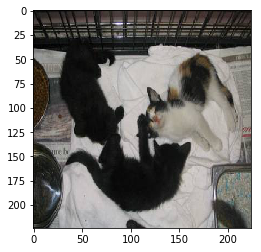

In [38]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
#指定非洲象图片存储路径
img_path2 = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/full_dataset_cat_dog/test/cats/cat.12436.jpg'
#通过target_size 指定图片加载尺寸为224 x 224，以适配VGG16模型
img2 = image.load_img(img_path2, target_size = (224, 224)) #要调整target size为VGG16默认input size
plt.imshow(img2)

In [39]:
extracted_features = model.predict(preprocess_img(img2))
pred = clf.predict(extracted_features)
pred

array([0.])

#### 特别注意，与全连接型分类器相比，支持向量分类机输出预测分类结果为二元结果，即0.或1.，而不是介于[0,1]之间的概率

#### 测试图片2

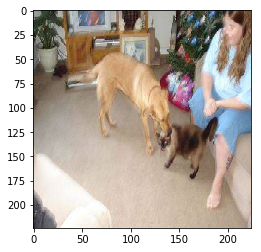

In [40]:
#指定非洲象图片存储路径
img_path2 = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/full_dataset_cat_dog/test/dogs/dog.12005.jpg'
#通过target_size 指定图片加载尺寸为224 x 224，以适配VGG16模型
img2 = image.load_img(img_path2, target_size = (224, 224))
plt.imshow(img2)

In [41]:
extracted_features = model.predict(preprocess_img(img2))
pred = clf.predict(extracted_features)
pred

array([1.])

#### 模型在上述图像中优先识别出了狗

#### 测试图片3

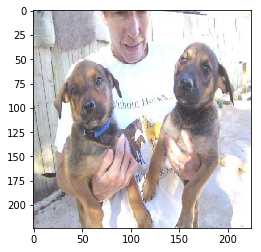

In [42]:
#指定非洲象图片存储路径
img_path2 = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/full_dataset_cat_dog/test/dogs/dog.12003.jpg'
#通过target_size 指定图片加载尺寸为224 x 224，以适配VGG16模型
img2 = image.load_img(img_path2, target_size = (224,224))
plt.imshow(img2)

In [43]:
extracted_features = model.predict(preprocess_img(img2))
pred = clf.predict(extracted_features)
pred

array([1.])